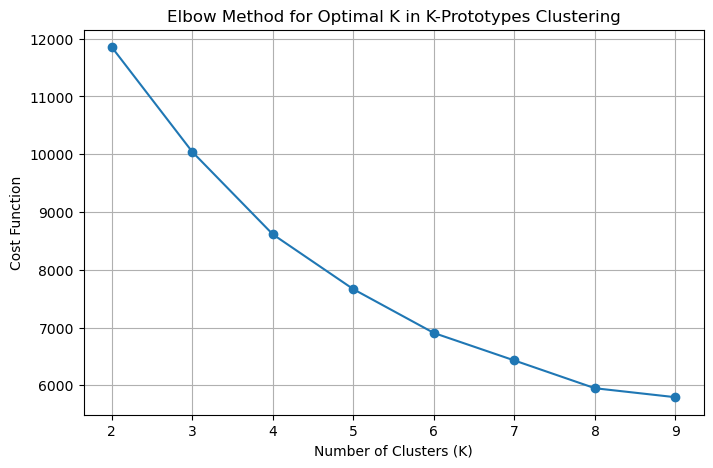

Silhouette Score: 0.0980


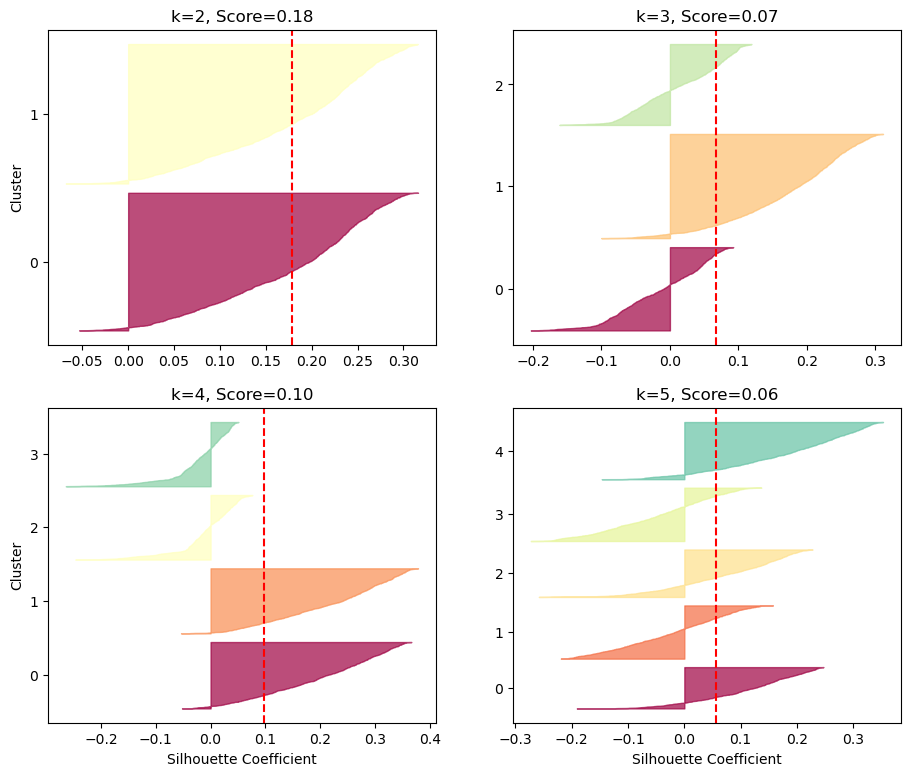

In [32]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from matplotlib.ticker import FixedLocator, FixedFormatter

# Load dataset
df = pd.read_csv("shopping_behavior_updated.csv").drop(columns=['Customer ID'])
features = ['Age','Gender','Purchase Amount (USD)','Previous Purchases'
            ,'Frequency of Purchases','Promo Code Used']
df = df[features]

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Encode categorical variables and scale numerical ones
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
scalers = {col: StandardScaler().fit(df[[col]]) for col in numerical_cols}

df_encoded = df.copy()
for col, encoder in label_encoders.items():
    df_encoded[col] = encoder.transform(df[col])
for col, scaler in scalers.items():
    df_encoded[col] = scaler.transform(df[[col]])

df_np = df_encoded.to_numpy()
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]

# Determine optimal K using Elbow Method
costs = []
K_range = range(2, 10)
for k in K_range:
    kp = KPrototypes(n_clusters=k, init="Cao", n_init=5, verbose=0)
    kp.fit_predict(df_np, categorical=categorical_indices)
    costs.append(kp.cost_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost Function")
plt.title("Elbow Method for Optimal K in K-Prototypes Clustering")
plt.grid(True)
plt.show()

# Apply K-Prototypes clustering with optimal K (assuming 4 based on plot)
optimal_k = 4
kproto = KPrototypes(n_clusters=optimal_k, init="Huang", n_init=5, verbose=0)
df_encoded["prod_cluster"] = kproto.fit_predict(df_np, categorical=categorical_indices)

# Decode categorical values back to original labels
def decode_cluster(row):
    for col in categorical_cols:
        row[col] = label_encoders[col].inverse_transform([int(row[col])])[0]
    return row

df_decoded = df_encoded.copy()
df_decoded[numerical_cols] = df[numerical_cols]  # Restore original scaled values
cluster_composition = df_decoded.groupby("prod_cluster").apply(lambda x: x.mode().iloc[0]).apply(decode_cluster, axis=1)

# Compute Silhouette Score with mixed distance function
def mixed_distance(a, b):
    num_distance = np.linalg.norm(a[:-len(categorical_indices)] - b[:-len(categorical_indices)])
    cat_distance = sum(a[categorical_indices] != b[categorical_indices])
    return num_distance + cat_distance

dist_matrix = cdist(df_np, df_np, metric=lambda u, v: mixed_distance(u, v))
silhouette_avg = silhouette_score(dist_matrix, df_encoded["prod_cluster"], metric='precomputed')
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Silhouette Analysis
plt.figure(figsize=(11, 9))
for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    y_pred = KPrototypes(n_clusters=k, init='Cao', n_init=5, verbose=0).fit_predict(df_np, categorical=categorical_indices)
    silhouette_coeffs = silhouette_samples(dist_matrix,y_pred, metric='precomputed')
    padding = len(df_np) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]
        coeffs.sort()
        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    if k in (4, 5):
        plt.xlabel("Silhouette Coefficient")
    plt.axvline(x=np.mean(silhouette_coeffs), color="red", linestyle="--")
    plt.title(f"k={k}, Score={np.mean(silhouette_coeffs):.2f}")
plt.show()


# RFM Approximation

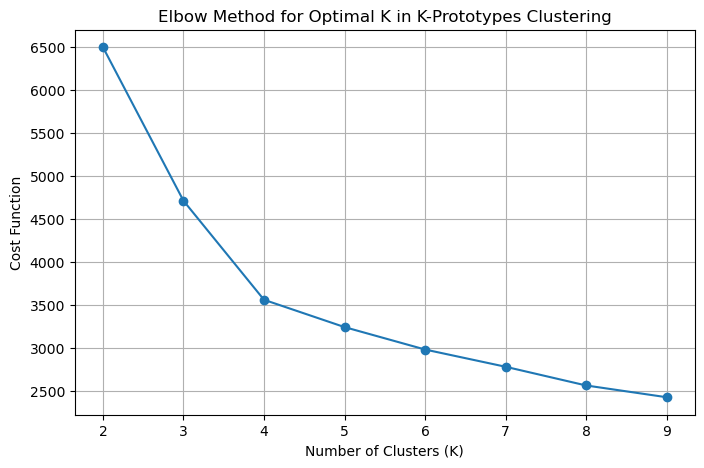

Silhouette Score: 0.2702


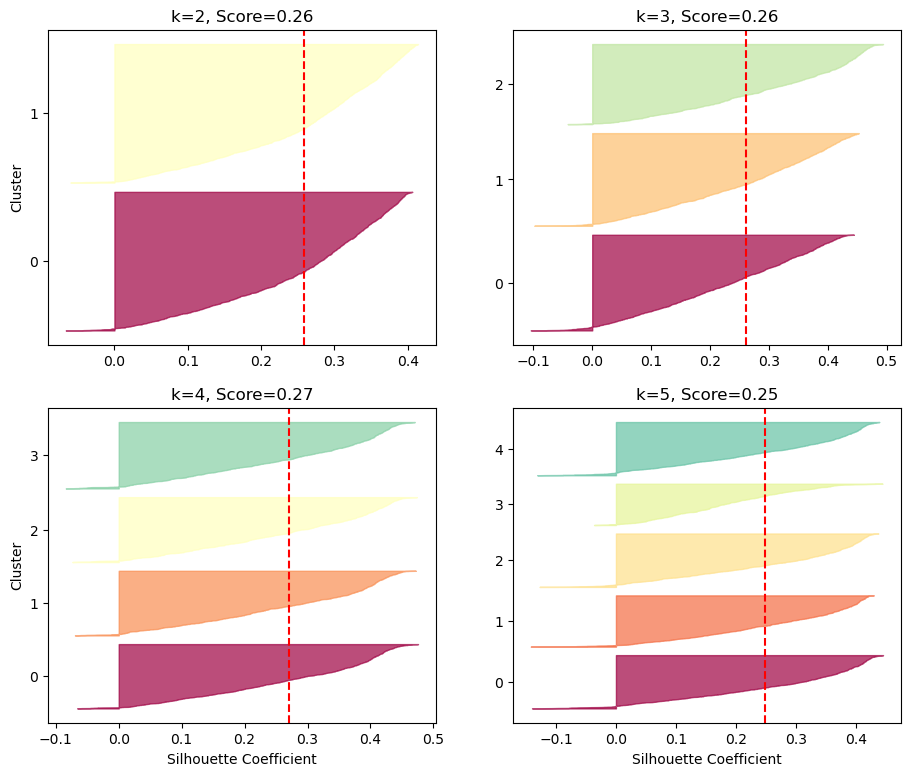

In [25]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist
from matplotlib.ticker import FixedLocator, FixedFormatter

# Load dataset
df = pd.read_csv("shopping_behavior_updated.csv").drop(columns=['Customer ID'])
features = ['Purchase Amount (USD)','Previous Purchases','Frequency of Purchases']
df = df[features]

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Encode categorical variables and scale numerical ones
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
scalers = {col: StandardScaler().fit(df[[col]]) for col in numerical_cols}

df_encoded = df.copy()
for col, encoder in label_encoders.items():
    df_encoded[col] = encoder.transform(df[col])
for col, scaler in scalers.items():
    df_encoded[col] = scaler.transform(df[[col]])

df_np = df_encoded.to_numpy()
categorical_indices = [df.columns.get_loc(col) for col in categorical_cols]

# Determine optimal K using Elbow Method
costs = []
K_range = range(2, 10)
for k in K_range:
    kp = KPrototypes(n_clusters=k, init="Cao", n_init=5, verbose=0)
    kp.fit_predict(df_np, categorical=categorical_indices)
    costs.append(kp.cost_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Cost Function")
plt.title("Elbow Method for Optimal K in K-Prototypes Clustering")
plt.grid(True)
plt.show()

# Apply K-Prototypes clustering with optimal K (assuming 4 based on plot)
optimal_k = 4
kproto = KPrototypes(n_clusters=optimal_k, init="Huang", n_init=5, verbose=0)
df_encoded["prod_cluster"] = kproto.fit_predict(df_np, categorical=categorical_indices)

# Decode categorical values back to original labels
def decode_cluster(row):
    for col in categorical_cols:
        row[col] = label_encoders[col].inverse_transform([int(row[col])])[0]
    return row

df_decoded = df_encoded.copy()
df_decoded[numerical_cols] = df[numerical_cols]  # Restore original scaled values
cluster_composition = df_decoded.groupby("prod_cluster").apply(lambda x: x.mode().iloc[0]).apply(decode_cluster, axis=1)

# Compute Silhouette Score with mixed distance function
def mixed_distance(a, b):
    num_distance = np.linalg.norm(a[:-len(categorical_indices)] - b[:-len(categorical_indices)])
    cat_distance = sum(a[categorical_indices] != b[categorical_indices])
    return num_distance + cat_distance

dist_matrix = cdist(df_np, df_np, metric=lambda u, v: mixed_distance(u, v))
silhouette_avg = silhouette_score(dist_matrix, df_encoded["prod_cluster"], metric='precomputed')
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Silhouette Analysis
plt.figure(figsize=(11, 9))
for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    y_pred = KPrototypes(n_clusters=k, init='Cao', n_init=5, verbose=0).fit_predict(df_np, categorical=categorical_indices)
    # silhouette_coeffs = silhouette_samples(df_np, y_pred)
    silhouette_coeffs = silhouette_samples(dist_matrix,y_pred, metric='precomputed')
    padding = len(df_np) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]
        coeffs.sort()
        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    if k in (4, 5):
        plt.xlabel("Silhouette Coefficient")
    plt.axvline(x=np.mean(silhouette_coeffs), color="red", linestyle="--")
    plt.title(f"k={k}, Score={np.mean(silhouette_coeffs):.2f}")
plt.show()
